In [32]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras. layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn import linear_model
import keras.backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import math
import time
from math import sqrt

In [33]:
# Fetching data

df = pd.read_csv('../data/dataset.csv')

<AxesSubplot:xlabel='Time'>

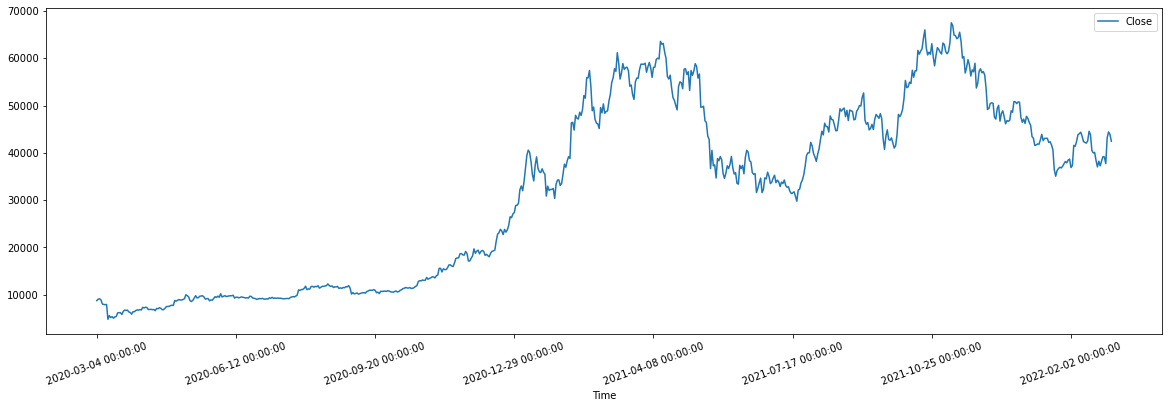

In [34]:
# Plotting btc prices
df.plot(x='Time', y='Close', kind='line', figsize=(20,6), rot=20)

## Feature Scaling

In [35]:
# Extracting closing prices
FullData=df[['Close']].values
print(FullData[0:5])
 
# Choosing between Standardization or normalization
sc = StandardScaler()
#sc=MinMaxScaler()
 
DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
#X=FullData
 
print('### After Standardization###')
X[0:5]

[[8750.7]
 [9056.9]
 [9134.3]
 [8889.9]
 [8036.5]]
### After Standardization###


array([[-1.23101849],
       [-1.21479378],
       [-1.21069256],
       [-1.22364266],
       [-1.26886201]])

In [36]:
test_size = 0.2                                                # proportion of dataset to be used as test set
cv_size = 0.2                                                   # proportion of dataset to be used as cross-validation set

In [37]:
num_cv = int(cv_size*len(X))
num_test = int(test_size*len(X))
num_train = len(X) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = X[:num_train]
cv = X[num_train:num_train+num_cv]
train_cv = X[:num_train+num_cv]
test = X[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 438
num_cv = 146
num_test = 146
train.shape = (438, 1)
cv.shape = (146, 1)
train_cv.shape = (584, 1)
test.shape = (146, 1)


In [38]:
# split into samples
def split(dataset):
    X_samples = list()
    y_samples = list()

    NumerOfRows = len(dataset)
    TimeSteps=5  # next day's Price Prediction is based on last how many past day's prices

    # Iterate thru the values to create combinations
    for i in range(TimeSteps , NumerOfRows , 1):
        x_sample = dataset[i-TimeSteps:i]
        y_sample = dataset[i]
        X_samples.append(x_sample)
        y_samples.append(y_sample)

    ################################################
    # Reshape the Input as a 3D (number of samples, Time Steps, Features)
    X_data=np.array(X_samples)
    X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
    print('\n#### Input Data shape ####')
    print(X_data.shape)

    # We do not reshape y as a 3D data  as it is supposed to be a single column only
    y_data=np.array(y_samples)
    y_data=y_data.reshape(y_data.shape[0], 1)
    print('\n#### Output Data shape ####')
    print(y_data.shape)
    
    return X_data, y_data

## Data Split

In [39]:
X_train, y_train = split(train)
X_cv, y_cv = split(cv)
X_train_cv, y_train_cv = split(train_cv)
X_test, y_test = split(test)


#### Input Data shape ####
(433, 5, 1)

#### Output Data shape ####
(433, 1)

#### Input Data shape ####
(141, 5, 1)

#### Output Data shape ####
(141, 1)

#### Input Data shape ####
(579, 5, 1)

#### Output Data shape ####
(579, 1)

#### Input Data shape ####
(141, 5, 1)

#### Output Data shape ####
(141, 1)


In [40]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 5
Number of Features: 1


In [41]:
def run(batchSize, numEpochs, X, Y, pred_set, actual_set):
    # Initialising the RNN
    regressor = Sequential()

    # Adding the First input hidden layer and the LSTM layer
    # return_sequences = True, means the output of every time step to be shared with hidden next layer
    regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

    # Adding the Second Second hidden layer and the LSTM layer
    regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

    # Adding the Second Third hidden layer and the LSTM layer
    regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))


    # Adding the output layer
    regressor.add(Dense(units = 1))

    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

    ##################################################
    
    # Fitting the RNN to the Training set
    regressor.fit(X, Y, batch_size = batchSize, epochs = numEpochs)
    predicted_Price = regressor.predict(pred_set)
    predicted_Price = DataScaler.inverse_transform(predicted_Price)

    orig = actual_set
    orig = DataScaler.inverse_transform(actual_set)

    rmse = sqrt(mean_squared_error(orig, predicted_Price))
    mape = get_mape(orig, predicted_Price)
    # Calculate RMSE
    print("RMSE on train set = %0.3f" % rmse)
    # Calculate MAPE
    print("MAPE on train set = %0.3f%%" % mape)

    return rmse, mape

In [42]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Tuning Epochs Parameter

In [55]:
# vary training batches
param_label = 'epochs'
param_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
error_rate = {param_label: [], 'rmse': [], 'mape': []}

for param in param_list:
    rmse, mape = run(32, param, X_train, y_train, X_cv, y_cv)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape'].append(mape)

error_rate = pd.DataFrame(error_rate)
error_rate

Epoch 1/100
14/14 [==============================] - 4s 9ms/step - loss: 1.1405
Epoch 2/100
14/14 [==============================] - 0s 8ms/step - loss: 1.0959
Epoch 3/100
14/14 [==============================] - 0s 6ms/step - loss: 1.0392
Epoch 4/100
14/14 [==============================] - 0s 6ms/step - loss: 0.9573
Epoch 5/100
14/14 [==============================] - 0s 7ms/step - loss: 0.8139
Epoch 6/100
14/14 [==============================] - 0s 7ms/step - loss: 0.5741
Epoch 7/100
14/14 [==============================] - 0s 7ms/step - loss: 0.4061
Epoch 8/100
14/14 [==============================] - 0s 7ms/step - loss: 0.3778
Epoch 9/100
14/14 [==============================] - 0s 7ms/step - loss: 0.3636
Epoch 10/100
14/14 [==============================] - 0s 7ms/step - loss: 0.3547
Epoch 11/100
14/14 [==============================] - 0s 7ms/step - loss: 0.3468
Epoch 12/100
14/14 [==============================] - 0s 7ms/step - loss: 0.3399
Epoch 13/100
14/14 [=================

14/14 [==============================] - 8s 7ms/step - loss: 1.1523
Epoch 2/200
14/14 [==============================] - 0s 5ms/step - loss: 1.1145
Epoch 3/200
14/14 [==============================] - 0s 5ms/step - loss: 1.0714
Epoch 4/200
14/14 [==============================] - 0s 5ms/step - loss: 1.0061
Epoch 5/200
14/14 [==============================] - 0s 6ms/step - loss: 0.8982
Epoch 6/200
14/14 [==============================] - 0s 5ms/step - loss: 0.6979
Epoch 7/200
14/14 [==============================] - 0s 5ms/step - loss: 0.4652
Epoch 8/200
14/14 [==============================] - 0s 5ms/step - loss: 0.3314
Epoch 9/200
14/14 [==============================] - 0s 5ms/step - loss: 0.1974
Epoch 10/200
14/14 [==============================] - 0s 5ms/step - loss: 0.0526
Epoch 11/200
14/14 [==============================] - 0s 5ms/step - loss: 0.0229
Epoch 12/200
14/14 [==============================] - 0s 6ms/step - loss: 0.0156
Epoch 13/200
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 0.0074
Epoch 103/200
14/14 [==============================] - 0s 5ms/step - loss: 0.0071
Epoch 104/200
14/14 [==============================] - 0s 5ms/step - loss: 0.0069
Epoch 105/200
14/14 [==============================] - 0s 5ms/step - loss: 0.0067
Epoch 106/200
14/14 [==============================] - 0s 5ms/step - loss: 0.0066
Epoch 107/200
14/14 [==============================] - 0s 5ms/step - loss: 0.0065
Epoch 108/200
14/14 [==============================] - 0s 5ms/step - loss: 0.0068
Epoch 109/200
14/14 [==============================] - 0s 5ms/step - loss: 0.0066
Epoch 110/200
14/14 [==============================] - 0s 5ms/step - loss: 0.0067
Epoch 111/200
14/14 [==============================] - 0s 5ms/step - loss: 0.0065
Epoch 112/200
14/14 [==============================] - 0s 5ms/step - loss: 0.0066
Epoch 113/200
14/14 [==============================] - 0s 5ms/step - loss: 0.0074
Epoch 114/200
14/14 [=========

14/14 [==============================] - 3s 6ms/step - loss: 1.1944
Epoch 2/300
14/14 [==============================] - 0s 6ms/step - loss: 1.1582
Epoch 3/300
14/14 [==============================] - 0s 5ms/step - loss: 1.1259
Epoch 4/300
14/14 [==============================] - 0s 5ms/step - loss: 1.0641
Epoch 5/300
14/14 [==============================] - 0s 5ms/step - loss: 0.9943
Epoch 6/300
14/14 [==============================] - 0s 5ms/step - loss: 0.8807
Epoch 7/300
14/14 [==============================] - 0s 5ms/step - loss: 0.6613
Epoch 8/300
14/14 [==============================] - 0s 5ms/step - loss: 0.2429
Epoch 9/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0506
Epoch 10/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0320
Epoch 11/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0218
Epoch 12/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0190
Epoch 13/300
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 103/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0103
Epoch 104/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 105/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 106/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0103
Epoch 107/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0103
Epoch 108/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 109/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0103
Epoch 110/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0103
Epoch 111/300
14/14 [==============================] - 0s 6ms/step - loss: 0.0101
Epoch 112/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0101
Epoch 113/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 114/300
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 203/300
14/14 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 204/300
14/14 [==============================] - 0s 6ms/step - loss: 0.0048
Epoch 205/300
14/14 [==============================] - 0s 6ms/step - loss: 0.0049
Epoch 206/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 207/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 208/300
14/14 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 209/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 210/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 211/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 212/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 213/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 214/300
14/14 [=========

14/14 [==============================] - 4s 6ms/step - loss: 1.1274
Epoch 2/400
14/14 [==============================] - 0s 5ms/step - loss: 1.0607
Epoch 3/400
14/14 [==============================] - 0s 5ms/step - loss: 0.9783
Epoch 4/400
14/14 [==============================] - 0s 5ms/step - loss: 0.8462
Epoch 5/400
14/14 [==============================] - 0s 5ms/step - loss: 0.6325
Epoch 6/400
14/14 [==============================] - 0s 5ms/step - loss: 0.4021
Epoch 7/400
14/14 [==============================] - 0s 5ms/step - loss: 0.3472
Epoch 8/400
14/14 [==============================] - 0s 5ms/step - loss: 0.3085
Epoch 9/400
14/14 [==============================] - 0s 8ms/step - loss: 0.2791
Epoch 10/400
14/14 [==============================] - 0s 6ms/step - loss: 0.2521
Epoch 11/400
14/14 [==============================] - 0s 5ms/step - loss: 0.2233
Epoch 12/400
14/14 [==============================] - 0s 5ms/step - loss: 0.1939
Epoch 13/400
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 0.0064
Epoch 103/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0065
Epoch 104/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0063
Epoch 105/400
14/14 [==============================] - 0s 6ms/step - loss: 0.0063
Epoch 106/400
14/14 [==============================] - 0s 6ms/step - loss: 0.0067
Epoch 107/400
14/14 [==============================] - 0s 6ms/step - loss: 0.0062
Epoch 108/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0062
Epoch 109/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0063
Epoch 110/400
14/14 [==============================] - 0s 6ms/step - loss: 0.0064
Epoch 111/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0061
Epoch 112/400
14/14 [==============================] - 0s 6ms/step - loss: 0.0060
Epoch 113/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0065
Epoch 114/400
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 203/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 204/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 205/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 206/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 207/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 208/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 209/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 210/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 211/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 212/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 213/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 214/400
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 303/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 304/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 305/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 306/400
14/14 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 307/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 308/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 309/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 310/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 311/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 312/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 313/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 314/400
14/14 [=========

14/14 [==============================] - 3s 6ms/step - loss: 1.1615
Epoch 2/500
14/14 [==============================] - 0s 5ms/step - loss: 1.1186
Epoch 3/500
14/14 [==============================] - 0s 5ms/step - loss: 1.0723
Epoch 4/500
14/14 [==============================] - 0s 5ms/step - loss: 1.0108
Epoch 5/500
14/14 [==============================] - 0s 5ms/step - loss: 0.9171
Epoch 6/500
14/14 [==============================] - 0s 5ms/step - loss: 0.7463
Epoch 7/500
14/14 [==============================] - 0s 5ms/step - loss: 0.4799
Epoch 8/500
14/14 [==============================] - 0s 5ms/step - loss: 0.3842
Epoch 9/500
14/14 [==============================] - 0s 5ms/step - loss: 0.3505
Epoch 10/500
14/14 [==============================] - 0s 5ms/step - loss: 0.3187
Epoch 11/500
14/14 [==============================] - 0s 5ms/step - loss: 0.2749
Epoch 12/500
14/14 [==============================] - 0s 5ms/step - loss: 0.1812
Epoch 13/500
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 0.0081
Epoch 103/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0080
Epoch 104/500
14/14 [==============================] - 0s 6ms/step - loss: 0.0079
Epoch 105/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0082
Epoch 106/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0078
Epoch 107/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0081
Epoch 108/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0078
Epoch 109/500
14/14 [==============================] - 0s 6ms/step - loss: 0.0074
Epoch 110/500
14/14 [==============================] - 0s 6ms/step - loss: 0.0078
Epoch 111/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0074
Epoch 112/500
14/14 [==============================] - 0s 6ms/step - loss: 0.0083
Epoch 113/500
14/14 [==============================] - 0s 7ms/step - loss: 0.0077
Epoch 114/500
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0074
Epoch 203/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0063
Epoch 204/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 205/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0058
Epoch 206/500
14/14 [==============================] - 0s 6ms/step - loss: 0.0059
Epoch 207/500
14/14 [==============================] - 0s 6ms/step - loss: 0.0058
Epoch 208/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0058
Epoch 209/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 210/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 211/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0059
Epoch 212/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0058
Epoch 213/500
14/14 [==============================] - 0s 6ms/step - loss: 0.0057
Epoch 214/500
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 303/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 304/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 305/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 306/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 307/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 308/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 309/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 310/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 311/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 312/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 313/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 314/500
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 403/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 404/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 405/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 406/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 407/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 408/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 409/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 410/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 411/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 412/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 413/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 414/500
14/14 [=========

14/14 [==============================] - 4s 6ms/step - loss: 1.1336
Epoch 2/600
14/14 [==============================] - 0s 6ms/step - loss: 1.0899
Epoch 3/600
14/14 [==============================] - 0s 5ms/step - loss: 1.0334
Epoch 4/600
14/14 [==============================] - 0s 5ms/step - loss: 0.9517
Epoch 5/600
14/14 [==============================] - 0s 5ms/step - loss: 0.8089
Epoch 6/600
14/14 [==============================] - 0s 5ms/step - loss: 0.5747
Epoch 7/600
14/14 [==============================] - 0s 5ms/step - loss: 0.4316
Epoch 8/600
14/14 [==============================] - 0s 5ms/step - loss: 0.3897
Epoch 9/600
14/14 [==============================] - 0s 6ms/step - loss: 0.3562
Epoch 10/600
14/14 [==============================] - 0s 5ms/step - loss: 0.3269
Epoch 11/600
14/14 [==============================] - 0s 5ms/step - loss: 0.3018
Epoch 12/600
14/14 [==============================] - 0s 5ms/step - loss: 0.2791
Epoch 13/600
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 0.0063
Epoch 103/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 104/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0061
Epoch 105/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0061
Epoch 106/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0063
Epoch 107/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0061
Epoch 108/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0061
Epoch 109/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0061
Epoch 110/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 111/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0059
Epoch 112/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 113/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0061
Epoch 114/600
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 203/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0054
Epoch 204/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 205/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0058
Epoch 206/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0060
Epoch 207/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 208/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0056
Epoch 209/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0056
Epoch 210/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 211/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0059
Epoch 212/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0058
Epoch 213/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0056
Epoch 214/600
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 303/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 304/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 305/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 306/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0056
Epoch 307/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 308/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 309/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 310/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 311/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 312/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 313/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 314/600
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 403/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 404/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 405/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 406/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 407/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 408/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 409/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 410/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 411/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0051
Epoch 412/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 413/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 414/600
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 503/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 504/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 505/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 506/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 507/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 508/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 509/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 510/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 511/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 512/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 513/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 514/600
14/14 [=========

14/14 [==============================] - 3s 6ms/step - loss: 1.1624
Epoch 2/700
14/14 [==============================] - 0s 6ms/step - loss: 1.1212
Epoch 3/700
14/14 [==============================] - 0s 5ms/step - loss: 1.0811
Epoch 4/700
14/14 [==============================] - 0s 5ms/step - loss: 1.0255
Epoch 5/700
14/14 [==============================] - 0s 5ms/step - loss: 0.9278
Epoch 6/700
14/14 [==============================] - 0s 5ms/step - loss: 0.7298
Epoch 7/700
14/14 [==============================] - 0s 5ms/step - loss: 0.4943
Epoch 8/700
14/14 [==============================] - 0s 5ms/step - loss: 0.4407
Epoch 9/700
14/14 [==============================] - 0s 5ms/step - loss: 0.4000
Epoch 10/700
14/14 [==============================] - 0s 5ms/step - loss: 0.3608
Epoch 11/700
14/14 [==============================] - 0s 5ms/step - loss: 0.3376
Epoch 12/700
14/14 [==============================] - 0s 5ms/step - loss: 0.3193
Epoch 13/700
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 103/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0061
Epoch 104/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 105/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0066
Epoch 106/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0062
Epoch 107/700
14/14 [==============================] - 0s 6ms/step - loss: 0.0057
Epoch 108/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0066
Epoch 109/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 110/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0068
Epoch 111/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0063
Epoch 112/700
14/14 [==============================] - 0s 6ms/step - loss: 0.0058
Epoch 113/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 114/700
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 203/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 204/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 205/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 206/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 207/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 208/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 209/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 210/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 211/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 212/700
14/14 [==============================] - 0s 6ms/step - loss: 0.0051
Epoch 213/700
14/14 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 214/700
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 303/700
14/14 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 304/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 305/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 306/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 307/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 308/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 309/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 310/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 311/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 312/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 313/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 314/700
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 403/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 404/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 405/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 406/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 407/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 408/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 409/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 410/700
14/14 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 411/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 412/700
14/14 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 413/700
14/14 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 414/700
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 503/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 504/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 505/700
14/14 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 506/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 507/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 508/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 509/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 510/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 511/700
14/14 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 512/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 513/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 514/700
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 603/700
14/14 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 604/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 605/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 606/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 607/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 608/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 609/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 610/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 611/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 612/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 613/700
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 614/700
14/14 [=========

14/14 [==============================] - 4s 6ms/step - loss: 1.1640
Epoch 2/800
14/14 [==============================] - 0s 5ms/step - loss: 1.1273
Epoch 3/800
14/14 [==============================] - 0s 5ms/step - loss: 1.0921
Epoch 4/800
14/14 [==============================] - 0s 5ms/step - loss: 1.0455
Epoch 5/800
14/14 [==============================] - 0s 5ms/step - loss: 0.9717
Epoch 6/800
14/14 [==============================] - 0s 6ms/step - loss: 0.8307
Epoch 7/800
14/14 [==============================] - 0s 5ms/step - loss: 0.5578
Epoch 8/800
14/14 [==============================] - 0s 5ms/step - loss: 0.4293
Epoch 9/800
14/14 [==============================] - 0s 5ms/step - loss: 0.4043
Epoch 10/800
14/14 [==============================] - 0s 5ms/step - loss: 0.3859
Epoch 11/800
14/14 [==============================] - 0s 5ms/step - loss: 0.3706
Epoch 12/800
14/14 [==============================] - 0s 6ms/step - loss: 0.3568
Epoch 13/800
14/14 [=============================

14/14 [==============================] - 0s 5ms/step - loss: 0.0532
Epoch 103/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0518
Epoch 104/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0507
Epoch 105/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0496
Epoch 106/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0485
Epoch 107/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0477
Epoch 108/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0462
Epoch 109/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 110/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0442
Epoch 111/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0430
Epoch 112/800
14/14 [==============================] - 0s 7ms/step - loss: 0.0421
Epoch 113/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0411
Epoch 114/800
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 203/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 204/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 205/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0092
Epoch 206/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0087
Epoch 207/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0088
Epoch 208/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0088
Epoch 209/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0087
Epoch 210/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0086
Epoch 211/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0087
Epoch 212/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0084
Epoch 213/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0082
Epoch 214/800
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0061
Epoch 303/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 304/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0063
Epoch 305/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 306/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0063
Epoch 307/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0059
Epoch 308/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 309/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0061
Epoch 310/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0062
Epoch 311/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0059
Epoch 312/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0059
Epoch 313/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0061
Epoch 314/800
14/14 [=========

14/14 [==============================] - 0s 6ms/step - loss: 0.0058
Epoch 403/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 404/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 405/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 406/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 407/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 408/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 409/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0056
Epoch 410/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 411/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 412/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 413/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 414/800
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 503/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 504/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 505/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 506/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 507/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 508/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 509/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 510/800
14/14 [==============================] - 0s 7ms/step - loss: 0.0047
Epoch 511/800
14/14 [==============================] - 0s 7ms/step - loss: 0.0050
Epoch 512/800
14/14 [==============================] - 0s 8ms/step - loss: 0.0047
Epoch 513/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 514/800
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 603/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 604/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 605/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 606/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 607/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 608/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 609/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 610/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 611/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 612/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0049
Epoch 613/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 614/800
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 703/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 704/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 705/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 706/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 707/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 708/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 709/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 710/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 711/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 712/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 713/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 714/800
14/14 [=========

14/14 [==============================] - 3s 6ms/step - loss: 1.1560
Epoch 2/900
14/14 [==============================] - 0s 5ms/step - loss: 1.1231
Epoch 3/900
14/14 [==============================] - 0s 5ms/step - loss: 1.0825
Epoch 4/900
14/14 [==============================] - 0s 5ms/step - loss: 1.0255
Epoch 5/900
14/14 [==============================] - 0s 6ms/step - loss: 0.9309
Epoch 6/900
14/14 [==============================] - 0s 5ms/step - loss: 0.7438
Epoch 7/900
14/14 [==============================] - 0s 5ms/step - loss: 0.5343
Epoch 8/900
14/14 [==============================] - 0s 5ms/step - loss: 0.3907
Epoch 9/900
14/14 [==============================] - 0s 5ms/step - loss: 0.2187
Epoch 10/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0692
Epoch 11/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0487
Epoch 12/900
14/14 [==============================] - 0s 6ms/step - loss: 0.0364
Epoch 13/900
14/14 [=============================

14/14 [==============================] - 0s 6ms/step - loss: 0.0106
Epoch 103/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0106
Epoch 104/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 105/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 106/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 107/900
14/14 [==============================] - 0s 6ms/step - loss: 0.0105
Epoch 108/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0106
Epoch 109/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0101
Epoch 110/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0102
Epoch 111/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0102
Epoch 112/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0100
Epoch 113/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0098
Epoch 114/900
14/14 [=========

14/14 [==============================] - 0s 6ms/step - loss: 0.0054
Epoch 203/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 204/900
14/14 [==============================] - 0s 12ms/step - loss: 0.0056
Epoch 205/900
14/14 [==============================] - 0s 12ms/step - loss: 0.0056
Epoch 206/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 207/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 208/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 209/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 210/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 211/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 212/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 213/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 214/900
14/14 [=======

14/14 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 303/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 304/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 305/900
14/14 [==============================] - 0s 6ms/step - loss: 0.0051
Epoch 306/900
14/14 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 307/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 308/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 309/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 310/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 311/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 312/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 313/900
14/14 [==============================] - 0s 6ms/step - loss: 0.0049
Epoch 314/900
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 403/900
14/14 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 404/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 405/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 406/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 407/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 408/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 409/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 410/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 411/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 412/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 413/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 414/900
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 503/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 504/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 505/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 506/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 507/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 508/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 509/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 510/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 511/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 512/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 513/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 514/900
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 603/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 604/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 605/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 606/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 607/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 608/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 609/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 610/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 611/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 612/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 613/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 614/900
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 703/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 704/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 705/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 706/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 707/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 708/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 709/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 710/900
14/14 [==============================] - 0s 6ms/step - loss: 0.0040
Epoch 711/900
14/14 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 712/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 713/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 714/900
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 803/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 804/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 805/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 806/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 807/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 808/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 809/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 810/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 811/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 812/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 813/900
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 814/900
14/14 [=========

14/14 [==============================] - 4s 6ms/step - loss: 1.1000
Epoch 2/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0072
Epoch 3/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.8611
Epoch 4/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.6123
Epoch 5/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.4025
Epoch 6/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.3566
Epoch 7/1000
14/14 [==============================] - 0s 6ms/step - loss: 0.3192
Epoch 8/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.2803
Epoch 9/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.2348
Epoch 10/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.1623
Epoch 11/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0586
Epoch 12/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0319
Epoch 13/1000
14/14 [=================

14/14 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 102/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0070
Epoch 103/1000
14/14 [==============================] - 0s 6ms/step - loss: 0.0062
Epoch 104/1000
14/14 [==============================] - 0s 6ms/step - loss: 0.0059
Epoch 105/1000
14/14 [==============================] - 0s 6ms/step - loss: 0.0060
Epoch 106/1000
14/14 [==============================] - 0s 6ms/step - loss: 0.0064
Epoch 107/1000
14/14 [==============================] - 0s 6ms/step - loss: 0.0064
Epoch 108/1000
14/14 [==============================] - 0s 6ms/step - loss: 0.0061
Epoch 109/1000
14/14 [==============================] - 0s 6ms/step - loss: 0.0059
Epoch 110/1000
14/14 [==============================] - 0s 6ms/step - loss: 0.0060
Epoch 111/1000
14/14 [==============================] - 0s 6ms/step - loss: 0.0067
Epoch 112/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0058
Epoch 113/1000
14/1

14/14 [==============================] - 0s 6ms/step - loss: 0.0051
Epoch 200/1000
14/14 [==============================] - 0s 6ms/step - loss: 0.0052
Epoch 201/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 202/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 203/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 204/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 205/1000
14/14 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 206/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 207/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 208/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 209/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 210/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 211/1000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 298/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 299/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 300/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 301/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 302/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 303/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 304/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 305/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 306/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 307/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 308/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 309/1000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 396/1000
14/14 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 397/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 398/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 399/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 400/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 401/1000
14/14 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 402/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 403/1000
14/14 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 404/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 405/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 406/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 407/1000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 494/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 495/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 496/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 497/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 498/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 499/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 500/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 501/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 502/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 503/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 504/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 505/1000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 592/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 593/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 594/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 595/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 596/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 597/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 598/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 599/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 600/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 601/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 602/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 603/1000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 690/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 691/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 692/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 693/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 694/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 695/1000
14/14 [==============================] - 0s 8ms/step - loss: 0.0042
Epoch 696/1000
14/14 [==============================] - 0s 9ms/step - loss: 0.0044
Epoch 697/1000
14/14 [==============================] - 0s 7ms/step - loss: 0.0042
Epoch 698/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 699/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 700/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 701/1000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 788/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0039
Epoch 789/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 790/1000
14/14 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 791/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 792/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 793/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 794/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 795/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 796/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 797/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 798/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 799/1000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 886/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 887/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 888/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 889/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 890/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0039
Epoch 891/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 892/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 893/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 894/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 895/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 896/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 897/1000
14/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 984/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 985/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 986/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 987/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 988/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0039
Epoch 989/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0039
Epoch 990/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 991/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 992/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 993/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 994/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 995/1000
14/1

,epochs,rmse,mape
0,100,2609.749708,5.195116
1,200,2330.619315,4.803843
2,300,1860.146891,3.718159
3,400,1985.088433,4.014682
4,500,1897.239292,3.691311
5,600,2140.674046,4.383213
6,700,1738.260054,3.338260
7,800,2009.115967,3.865300
8,900,1887.401285,3.687005
9,1000,1780.215668,3.453402


In [56]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epoch_opt = temp['epochs'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = " + str(epoch_opt))

min RMSE = 1738.260
optimum params = 700


In [57]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = " + str(temp['epochs'].values[0]))

min MAPE = 3.338%
optimum params = 700


## Tuning Batch Size Parameter

In [47]:
# vary training batches
param_label = 'batch_size'
param_list = [32, 64, 128, 256]
error_rate = {param_label: [], 'rmse': [], 'mape': []}

for param in param_list:
    rmse, mape = run(param, epoch_opt, X_train, y_train, X_cv, y_cv)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape'].append(mape)

error_rate = pd.DataFrame(error_rate)
error_rate

Epoch 1/800
14/14 [==============================] - 4s 7ms/step - loss: 1.1626
Epoch 2/800
14/14 [==============================] - 0s 6ms/step - loss: 1.1271
Epoch 3/800
14/14 [==============================] - 0s 6ms/step - loss: 1.0856
Epoch 4/800
14/14 [==============================] - 0s 6ms/step - loss: 1.0333
Epoch 5/800
14/14 [==============================] - 0s 6ms/step - loss: 0.9571
Epoch 6/800
14/14 [==============================] - 0s 6ms/step - loss: 0.8326
Epoch 7/800
14/14 [==============================] - 0s 7ms/step - loss: 0.6031
Epoch 8/800
14/14 [==============================] - 0s 7ms/step - loss: 0.3085
Epoch 9/800
14/14 [==============================] - 0s 7ms/step - loss: 0.1004
Epoch 10/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0436
Epoch 11/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0300
Epoch 12/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0233
Epoch 13/800
14/14 [=================

14/14 [==============================] - 0s 6ms/step - loss: 0.0070
Epoch 103/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0071
Epoch 104/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0077
Epoch 105/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0096
Epoch 106/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0076
Epoch 107/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0070
Epoch 108/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0071
Epoch 109/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0073
Epoch 110/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0069
Epoch 111/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0069
Epoch 112/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0068
Epoch 113/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0067
Epoch 114/800
14/14 [=========

14/14 [==============================] - 0s 11ms/step - loss: 0.0059
Epoch 203/800
14/14 [==============================] - 0s 7ms/step - loss: 0.0056
Epoch 204/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0055
Epoch 205/800
14/14 [==============================] - 0s 7ms/step - loss: 0.0056
Epoch 206/800
14/14 [==============================] - 0s 7ms/step - loss: 0.0060
Epoch 207/800
14/14 [==============================] - 0s 9ms/step - loss: 0.0055
Epoch 208/800
14/14 [==============================] - 0s 7ms/step - loss: 0.0058
Epoch 209/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0055
Epoch 210/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0056
Epoch 211/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 212/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0059
Epoch 213/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0058
Epoch 214/800
14/14 [========

14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 303/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 304/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 305/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 306/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 307/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 308/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 309/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 310/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 311/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 312/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 313/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 314/800
14/14 [=========

14/14 [==============================] - 0s 12ms/step - loss: 0.0044
Epoch 403/800
14/14 [==============================] - 0s 8ms/step - loss: 0.0042
Epoch 404/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 405/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 406/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 407/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 408/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 409/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 410/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 411/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 412/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 413/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 414/800
14/14 [========

14/14 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 503/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 504/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 505/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 506/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 507/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 508/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 509/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 510/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 511/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 512/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 513/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 514/800
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 603/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0039
Epoch 604/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 605/800
14/14 [==============================] - 0s 7ms/step - loss: 0.0042
Epoch 606/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 607/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 608/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 609/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 610/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 611/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 612/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 613/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 614/800
14/14 [=========

14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 703/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 704/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 705/800
14/14 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 706/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 707/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 708/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 709/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 710/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 711/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 712/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 713/800
14/14 [==============================] - 0s 6ms/step - loss: 0.0040
Epoch 714/800
14/14 [=========

7/7 [==============================] - 4s 10ms/step - loss: 1.1628
Epoch 2/800
7/7 [==============================] - 0s 7ms/step - loss: 1.1450
Epoch 3/800
7/7 [==============================] - 0s 6ms/step - loss: 1.1273
Epoch 4/800
7/7 [==============================] - 0s 6ms/step - loss: 1.1093
Epoch 5/800
7/7 [==============================] - 0s 7ms/step - loss: 1.0895
Epoch 6/800
7/7 [==============================] - 0s 7ms/step - loss: 1.0678
Epoch 7/800
7/7 [==============================] - 0s 7ms/step - loss: 1.0427
Epoch 8/800
7/7 [==============================] - 0s 6ms/step - loss: 1.0101
Epoch 9/800
7/7 [==============================] - 0s 6ms/step - loss: 0.9726
Epoch 10/800
7/7 [==============================] - 0s 6ms/step - loss: 0.9207
Epoch 11/800
7/7 [==============================] - 0s 6ms/step - loss: 0.8528
Epoch 12/800
7/7 [==============================] - 0s 7ms/step - loss: 0.7581
Epoch 13/800
7/7 [==============================] - 0s 6ms/step - loss: 

7/7 [==============================] - 0s 6ms/step - loss: 0.0063
Epoch 105/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0064
Epoch 106/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0068
Epoch 107/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0062
Epoch 108/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0062
Epoch 109/800
7/7 [==============================] - 0s 7ms/step - loss: 0.0063
Epoch 110/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0066
Epoch 111/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0064
Epoch 112/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0070
Epoch 113/800
7/7 [==============================] - 0s 7ms/step - loss: 0.0073
Epoch 114/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0077
Epoch 115/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0076
Epoch 116/800
7/7 [==============================] - 0

7/7 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 207/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0052
Epoch 208/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0054
Epoch 209/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0057
Epoch 210/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0061
Epoch 211/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0054
Epoch 212/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 213/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0056
Epoch 214/800
7/7 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 215/800
7/7 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 216/800
7/7 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 217/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0054
Epoch 218/800
7/7 [==============================] - 0

7/7 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 309/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0051
Epoch 310/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0049
Epoch 311/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0051
Epoch 312/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0052
Epoch 313/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 314/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0051
Epoch 315/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0048
Epoch 316/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0049
Epoch 317/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0055
Epoch 318/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0051
Epoch 319/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0049
Epoch 320/800
7/7 [==============================] - 0

7/7 [==============================] - 0s 6ms/step - loss: 0.0048
Epoch 411/800
7/7 [==============================] - 0s 7ms/step - loss: 0.0051
Epoch 412/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0051
Epoch 413/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 414/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0052
Epoch 415/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 416/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0051
Epoch 417/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 418/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 419/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 420/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 421/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 422/800
7/7 [==============================] - 0

7/7 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 513/800
7/7 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 514/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 515/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 516/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 517/800
7/7 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 518/800
7/7 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 519/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 520/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 521/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 522/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 523/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 524/800
7/7 [==============================] - 0

7/7 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 615/800
7/7 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 616/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 617/800
7/7 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 618/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0057
Epoch 619/800
7/7 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 620/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 621/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 622/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 623/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 624/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 625/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 626/800
7/7 [==============================] - 0

7/7 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 717/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0041
Epoch 718/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 719/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 720/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 721/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 722/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0048
Epoch 723/800
7/7 [==============================] - 0s 7ms/step - loss: 0.0045
Epoch 724/800
7/7 [==============================] - 0s 7ms/step - loss: 0.0044
Epoch 725/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 726/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 727/800
7/7 [==============================] - 0s 6ms/step - loss: 0.0041
Epoch 728/800
7/7 [==============================] - 0

4/4 [==============================] - 0s 7ms/step - loss: 0.4705
Epoch 19/800
4/4 [==============================] - 0s 7ms/step - loss: 0.4238
Epoch 20/800
4/4 [==============================] - 0s 7ms/step - loss: 0.4260
Epoch 21/800
4/4 [==============================] - 0s 6ms/step - loss: 0.4270
Epoch 22/800
4/4 [==============================] - 0s 7ms/step - loss: 0.4044
Epoch 23/800
4/4 [==============================] - 0s 6ms/step - loss: 0.3942
Epoch 24/800
4/4 [==============================] - 0s 6ms/step - loss: 0.3920
Epoch 25/800
4/4 [==============================] - 0s 7ms/step - loss: 0.3864
Epoch 26/800
4/4 [==============================] - 0s 6ms/step - loss: 0.3778
Epoch 27/800
4/4 [==============================] - 0s 8ms/step - loss: 0.3713
Epoch 28/800
4/4 [==============================] - 0s 6ms/step - loss: 0.3670
Epoch 29/800
4/4 [==============================] - 0s 6ms/step - loss: 0.3619
Epoch 30/800
4/4 [==============================] - 0s 6ms/step -

4/4 [==============================] - 0s 6ms/step - loss: 0.0113
Epoch 122/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0113
Epoch 123/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0112
Epoch 124/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0112
Epoch 125/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0112
Epoch 126/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0114
Epoch 127/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0112
Epoch 128/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0110
Epoch 129/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0109
Epoch 130/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0109
Epoch 131/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0109
Epoch 132/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0108
Epoch 133/800
4/4 [==============================] - 0

4/4 [==============================] - 0s 6ms/step - loss: 0.0063
Epoch 224/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0063
Epoch 225/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0062
Epoch 226/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0062
Epoch 227/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0061
Epoch 228/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0062
Epoch 229/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0061
Epoch 230/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0062
Epoch 231/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0062
Epoch 232/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0062
Epoch 233/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0060
Epoch 234/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0062
Epoch 235/800
4/4 [==============================] - 0

4/4 [==============================] - 0s 8ms/step - loss: 0.0055
Epoch 326/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0054
Epoch 327/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0053
Epoch 328/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0054
Epoch 329/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0055
Epoch 330/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0053
Epoch 331/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0056
Epoch 332/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 333/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 334/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 335/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0053
Epoch 336/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0054
Epoch 337/800
4/4 [==============================] - 0

4/4 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 428/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0049
Epoch 429/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0049
Epoch 430/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0050
Epoch 431/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0049
Epoch 432/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 433/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0049
Epoch 434/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0049
Epoch 435/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0052
Epoch 436/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0049
Epoch 437/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 438/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0048
Epoch 439/800
4/4 [==============================] - 0

4/4 [==============================] - 0s 10ms/step - loss: 0.0047
Epoch 530/800
4/4 [==============================] - 0s 9ms/step - loss: 0.0048
Epoch 531/800
4/4 [==============================] - 0s 9ms/step - loss: 0.0047
Epoch 532/800
4/4 [==============================] - 0s 11ms/step - loss: 0.0048
Epoch 533/800
4/4 [==============================] - 0s 9ms/step - loss: 0.0048
Epoch 534/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 535/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0048
Epoch 536/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 537/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0047
Epoch 538/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 539/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 540/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0049
Epoch 541/800
4/4 [==============================] -

4/4 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 632/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0046
Epoch 633/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0049
Epoch 634/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0047
Epoch 635/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 636/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 637/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0046
Epoch 638/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 639/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0046
Epoch 640/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0045
Epoch 641/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 642/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0045
Epoch 643/800
4/4 [==============================] - 0

4/4 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 734/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 735/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 736/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 737/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 738/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0046
Epoch 739/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 740/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 741/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 742/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 743/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 744/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 745/800
4/4 [==============================] - 0

2/2 [==============================] - 0s 6ms/step - loss: 0.7639
Epoch 36/800
2/2 [==============================] - 0s 7ms/step - loss: 0.7337
Epoch 37/800
2/2 [==============================] - 0s 6ms/step - loss: 0.7020
Epoch 38/800
2/2 [==============================] - 0s 7ms/step - loss: 0.6675
Epoch 39/800
2/2 [==============================] - 0s 8ms/step - loss: 0.6290
Epoch 40/800
2/2 [==============================] - 0s 7ms/step - loss: 0.5881
Epoch 41/800
2/2 [==============================] - 0s 7ms/step - loss: 0.5442
Epoch 42/800
2/2 [==============================] - 0s 7ms/step - loss: 0.4970
Epoch 43/800
2/2 [==============================] - 0s 7ms/step - loss: 0.4472
Epoch 44/800
2/2 [==============================] - 0s 9ms/step - loss: 0.3941
Epoch 45/800
2/2 [==============================] - 0s 7ms/step - loss: 0.3393
Epoch 46/800
2/2 [==============================] - 0s 9ms/step - loss: 0.2840
Epoch 47/800
2/2 [==============================] - 0s 8ms/step -

2/2 [==============================] - 0s 7ms/step - loss: 0.0140
Epoch 139/800
2/2 [==============================] - 0s 9ms/step - loss: 0.0140
Epoch 140/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0140
Epoch 141/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0140
Epoch 142/800
2/2 [==============================] - 0s 9ms/step - loss: 0.0140
Epoch 143/800
2/2 [==============================] - 0s 9ms/step - loss: 0.0140
Epoch 144/800
2/2 [==============================] - 0s 9ms/step - loss: 0.0140
Epoch 145/800
2/2 [==============================] - 0s 9ms/step - loss: 0.0140
Epoch 146/800
2/2 [==============================] - 0s 9ms/step - loss: 0.0140
Epoch 147/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0139
Epoch 148/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0140
Epoch 149/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0139
Epoch 150/800
2/2 [==============================] - 0

2/2 [==============================] - 0s 9ms/step - loss: 0.0129
Epoch 241/800
2/2 [==============================] - 0s 9ms/step - loss: 0.0129
Epoch 242/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0129
Epoch 243/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0129
Epoch 244/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0128
Epoch 245/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0128
Epoch 246/800
2/2 [==============================] - 0s 7ms/step - loss: 0.0128
Epoch 247/800
2/2 [==============================] - 0s 7ms/step - loss: 0.0128
Epoch 248/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0128
Epoch 249/800
2/2 [==============================] - 0s 7ms/step - loss: 0.0128
Epoch 250/800
2/2 [==============================] - 0s 7ms/step - loss: 0.0128
Epoch 251/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0127
Epoch 252/800
2/2 [==============================] - 0

2/2 [==============================] - 0s 10ms/step - loss: 0.0090
Epoch 343/800
2/2 [==============================] - 0s 7ms/step - loss: 0.0090
Epoch 344/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0089
Epoch 345/800
2/2 [==============================] - 0s 10ms/step - loss: 0.0088
Epoch 346/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0088
Epoch 347/800
2/2 [==============================] - 0s 9ms/step - loss: 0.0087
Epoch 348/800
2/2 [==============================] - 0s 9ms/step - loss: 0.0086
Epoch 349/800
2/2 [==============================] - 0s 9ms/step - loss: 0.0086
Epoch 350/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0085
Epoch 351/800
2/2 [==============================] - 0s 7ms/step - loss: 0.0086
Epoch 352/800
2/2 [==============================] - 0s 7ms/step - loss: 0.0084
Epoch 353/800
2/2 [==============================] - 0s 9ms/step - loss: 0.0085
Epoch 354/800
2/2 [==============================] -

2/2 [==============================] - 0s 9ms/step - loss: 0.0064
Epoch 445/800
2/2 [==============================] - 0s 7ms/step - loss: 0.0062
Epoch 446/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0063
Epoch 447/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0062
Epoch 448/800
2/2 [==============================] - 0s 7ms/step - loss: 0.0062
Epoch 449/800
2/2 [==============================] - 0s 11ms/step - loss: 0.0062
Epoch 450/800
2/2 [==============================] - 0s 7ms/step - loss: 0.0062
Epoch 451/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0062
Epoch 452/800
2/2 [==============================] - 0s 23ms/step - loss: 0.0062
Epoch 453/800
2/2 [==============================] - 0s 7ms/step - loss: 0.0061
Epoch 454/800
2/2 [==============================] - 0s 9ms/step - loss: 0.0063
Epoch 455/800
2/2 [==============================] - 0s 6ms/step - loss: 0.0062
Epoch 456/800
2/2 [==============================] -

2/2 [==============================] - 0s 9ms/step - loss: 0.0058
Epoch 547/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0058
Epoch 548/800
2/2 [==============================] - 0s 9ms/step - loss: 0.0060
Epoch 549/800
2/2 [==============================] - 0s 12ms/step - loss: 0.0059
Epoch 550/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0059
Epoch 551/800
2/2 [==============================] - 0s 7ms/step - loss: 0.0058
Epoch 552/800
2/2 [==============================] - 0s 10ms/step - loss: 0.0059
Epoch 553/800
2/2 [==============================] - 0s 7ms/step - loss: 0.0058
Epoch 554/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0058
Epoch 555/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0058
Epoch 556/800
2/2 [==============================] - 0s 10ms/step - loss: 0.0058
Epoch 557/800
2/2 [==============================] - 0s 10ms/step - loss: 0.0058
Epoch 558/800
2/2 [==============================]

2/2 [==============================] - 0s 12ms/step - loss: 0.0056
Epoch 649/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0055
Epoch 650/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0056
Epoch 651/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0056
Epoch 652/800
2/2 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 653/800
2/2 [==============================] - 0s 12ms/step - loss: 0.0055
Epoch 654/800
2/2 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 655/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0055
Epoch 656/800
2/2 [==============================] - 0s 11ms/step - loss: 0.0055
Epoch 657/800
2/2 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 658/800
2/2 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 659/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0055
Epoch 660/800
2/2 [==============================] 

2/2 [==============================] - 0s 7ms/step - loss: 0.0054
Epoch 751/800
2/2 [==============================] - 0s 9ms/step - loss: 0.0053
Epoch 752/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0054
Epoch 753/800
2/2 [==============================] - 0s 8ms/step - loss: 0.0056
Epoch 754/800
2/2 [==============================] - 0s 10ms/step - loss: 0.0053
Epoch 755/800
2/2 [==============================] - 0s 7ms/step - loss: 0.0056
Epoch 756/800
2/2 [==============================] - 0s 9ms/step - loss: 0.0056
Epoch 757/800
2/2 [==============================] - 0s 10ms/step - loss: 0.0055
Epoch 758/800
2/2 [==============================] - 0s 9ms/step - loss: 0.0056
Epoch 759/800
2/2 [==============================] - 0s 9ms/step - loss: 0.0056
Epoch 760/800
2/2 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 761/800
2/2 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 762/800
2/2 [==============================] -

,batch_size,rmse,mape
0,32,1812.767467,3.430882
1,64,2151.966834,4.370425
2,128,1920.356201,3.925304
3,256,2302.872919,4.793641


In [53]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
batch_size_opt = temp['batch_size'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = " + str(batch_size_opt))

min RMSE = 1812.767
optimum params = 32


In [54]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = " + str(temp['batch_size'].values[0]))

min MAPE = 3.431%
optimum params = 32


## Model with the Optimal Params

In [58]:
# Initialising the RNN
regressor = Sequential()

# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Second Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Second Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))


# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train_cv, y_train_cv, batch_size = 32, epochs = 700)

predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)

orig=y_test
orig=DataScaler.inverse_transform(y_test)

rmse = sqrt(mean_squared_error(orig, predicted_Price))
print("RMSE on test set = %0.3f" % rmse)
print("MAPE on test set = %0.3f%%" % get_mape(orig, predicted_Price))

Epoch 1/700
19/19 [==============================] - 5s 6ms/step - loss: 0.9424
Epoch 2/700
19/19 [==============================] - 0s 5ms/step - loss: 0.9058
Epoch 3/700
19/19 [==============================] - 0s 5ms/step - loss: 0.8540
Epoch 4/700
19/19 [==============================] - 0s 5ms/step - loss: 0.7559
Epoch 5/700
19/19 [==============================] - 0s 5ms/step - loss: 0.5306
Epoch 6/700
19/19 [==============================] - 0s 5ms/step - loss: 0.3005
Epoch 7/700
19/19 [==============================] - 0s 8ms/step - loss: 0.1871
Epoch 8/700
19/19 [==============================] - 0s 6ms/step - loss: 0.0512
Epoch 9/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0330
Epoch 10/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0280
Epoch 11/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0241
Epoch 12/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0236
Epoch 13/700
19/19 [=================

19/19 [==============================] - 0s 6ms/step - loss: 0.0081
Epoch 103/700
19/19 [==============================] - 0s 6ms/step - loss: 0.0078
Epoch 104/700
19/19 [==============================] - 0s 6ms/step - loss: 0.0076
Epoch 105/700
19/19 [==============================] - 0s 6ms/step - loss: 0.0077
Epoch 106/700
19/19 [==============================] - 0s 6ms/step - loss: 0.0078
Epoch 107/700
19/19 [==============================] - 0s 8ms/step - loss: 0.0080
Epoch 108/700
19/19 [==============================] - 0s 10ms/step - loss: 0.0076
Epoch 109/700
19/19 [==============================] - 0s 6ms/step - loss: 0.0078
Epoch 110/700
19/19 [==============================] - 0s 7ms/step - loss: 0.0076
Epoch 111/700
19/19 [==============================] - 0s 7ms/step - loss: 0.0076
Epoch 112/700
19/19 [==============================] - 0s 8ms/step - loss: 0.0076
Epoch 113/700
19/19 [==============================] - 0s 10ms/step - loss: 0.0079
Epoch 114/700
19/19 [=======

19/19 [==============================] - 0s 15ms/step - loss: 0.0057
Epoch 203/700
19/19 [==============================] - 0s 7ms/step - loss: 0.0058
Epoch 204/700
19/19 [==============================] - 0s 9ms/step - loss: 0.0058
Epoch 205/700
19/19 [==============================] - 0s 7ms/step - loss: 0.0056
Epoch 206/700
19/19 [==============================] - 0s 6ms/step - loss: 0.0057
Epoch 207/700
19/19 [==============================] - 0s 6ms/step - loss: 0.0064
Epoch 208/700
19/19 [==============================] - 0s 6ms/step - loss: 0.0056
Epoch 209/700
19/19 [==============================] - 0s 6ms/step - loss: 0.0059
Epoch 210/700
19/19 [==============================] - 0s 17ms/step - loss: 0.0060
Epoch 211/700
19/19 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 212/700
19/19 [==============================] - 0s 6ms/step - loss: 0.0062
Epoch 213/700
19/19 [==============================] - 0s 9ms/step - loss: 0.0074
Epoch 214/700
19/19 [=======

19/19 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 303/700
19/19 [==============================] - 0s 6ms/step - loss: 0.0059
Epoch 304/700
19/19 [==============================] - 0s 6ms/step - loss: 0.0058
Epoch 305/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 306/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 307/700
19/19 [==============================] - 0s 6ms/step - loss: 0.0059
Epoch 308/700
19/19 [==============================] - 0s 6ms/step - loss: 0.0055
Epoch 309/700
19/19 [==============================] - 0s 6ms/step - loss: 0.0058
Epoch 310/700
19/19 [==============================] - 0s 6ms/step - loss: 0.0055
Epoch 311/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 312/700
19/19 [==============================] - 0s 6ms/step - loss: 0.0054
Epoch 313/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0064
Epoch 314/700
19/19 [=========

19/19 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 403/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 404/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 405/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 406/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 407/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 408/700
19/19 [==============================] - 0s 6ms/step - loss: 0.0056
Epoch 409/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 410/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 411/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 412/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 413/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 414/700
19/19 [=========

19/19 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 503/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 504/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0059
Epoch 505/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 506/700
19/19 [==============================] - 0s 6ms/step - loss: 0.0054
Epoch 507/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0058
Epoch 508/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0061
Epoch 509/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 510/700
19/19 [==============================] - 0s 6ms/step - loss: 0.0052
Epoch 511/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 512/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 513/700
19/19 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 514/700
19/19 [=========

Epoch 602/700
19/19 [==============================] - 0s 8ms/step - loss: 0.0054
Epoch 603/700
19/19 [==============================] - 0s 9ms/step - loss: 0.0052
Epoch 604/700
19/19 [==============================] - 0s 7ms/step - loss: 0.0056
Epoch 605/700
19/19 [==============================] - 0s 9ms/step - loss: 0.0053
Epoch 606/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 607/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 608/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0058
Epoch 609/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 610/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 611/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 612/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 613/700
19/19 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 614/700
19

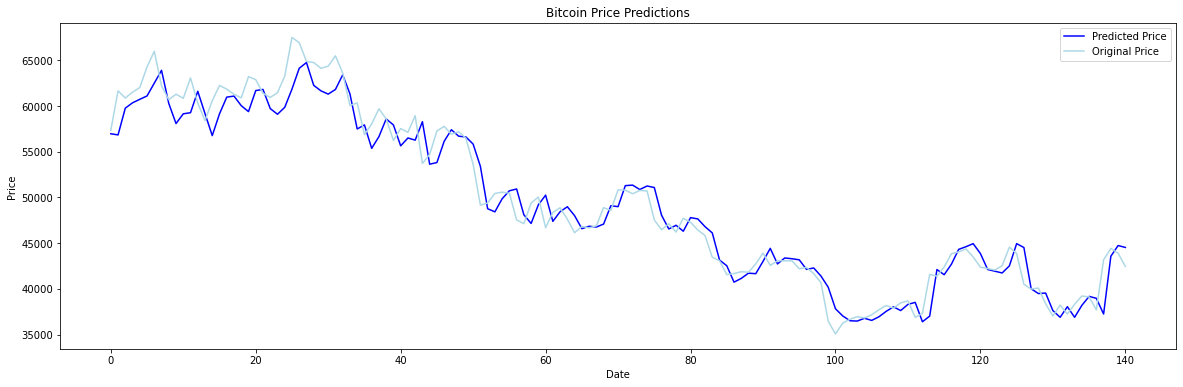

In [51]:
plt.plot(predicted_Price, color = 'blue', label = 'Predicted Price')
plt.plot(orig, color = 'lightblue', label = 'Original Price')
 
plt.title('Bitcoin Price Predictions')
plt.xlabel('Date')
#plt.xticks(range(141), df.tail(141)['Time'])
plt.xticks(np.arange(0, 160, step=20))  
plt.ylabel('Price')
 
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

In [ ]:
# Making predictions on test data
Last5DaysPrices=np.array([42456.3,43896.9,44428.2, 43179.8,37706.7])
 
# Reshaping the data to (-1,1 )because its a single entry
Last5DaysPrices=Last5DaysPrices.reshape(-1, 1)
 
# Scaling the data on the same level on which model was trained
X_test=DataScaler.transform(Last10DaysPrices)
 
NumberofSamples=1
TimeSteps=X_test.shape[0]
NumberofFeatures=X_test.shape[1]
# Reshaping the data as 3D input
X_test=X_test.reshape(NumberofSamples,TimeSteps,NumberofFeatures)
 
# Generating the predictions for next 5 days
NextDayPrice = regressor.predict(X_test)
 
# Generating the prices in original scale
NextDayPrice = DataScaler.inverse_transform(NextDayPrice)
NextDayPrice